# 🏃🐘 1. Building a Biometric Data Warehouse in PostgreSQL (ETL)

*Master in Data Science and Big Data*

*Author: Marcos Jiménez Juliana*

*Master's Thesis*

<a id = id_0><a/>
 
# Index

1. [Extracting and Transforming the data](#part_1)
   - 1.1. [Loading Data](#loading) 
   - 1.2. [Extracting Selected Variables](#extracting)
   - 1.3. [Validating Concatenation](#validating)
   - 1.4. [Joining Datasets](#joining)
   - 1.5. [Filtering the Dataset](#filtering)
   - 1.6. [Feature Engineering](#feature)
       - 1.6.1. [Creating New Variables](#feature)
       - 1.6.2. [Re-Encoding Invalid or Special Values](#special)
       - 1.6.3. [Handling Missing Data](#missing)
2. [Data Warehouse in PostgreSQL](#warehouse)
   - 2.1. [Connection to PostgreSQL](#connection)
   - 2.2. [Storing the Data](#storing)
   - 2.3. [Storing Metadata](#metadata)
<br>
<br>

![ETL](../images/ETL.png)


<a id = part_1><a/>

## 1. Extracting and Transforming the data

<a id = loading><a/>

### 1.1. Loading Data

In [1]:
import os 
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# The src folder is added to Python's search path
sys.path.append(os.path.abspath("../src"))

# My functions
import etl

In [2]:
folder_path = "../data/raw"
dataframes = etl.xpt_to_df(folder_path)

Loaded: ALQ_A with shape (4444, 9)
Loaded: ALQ_B with shape (5027, 9)
Loaded: ALQ_C with shape (4742, 9)
Loaded: BIX_A with shape (5311, 115)
Loaded: BIX_B with shape (5949, 115)
Loaded: BIX_C with shape (5329, 115)
Loaded: BMX_A with shape (9282, 38)
Loaded: BMX_B with shape (10477, 26)
Loaded: BMX_C with shape (9643, 33)
Loaded: BPX_A with shape (9282, 30)
Loaded: BPX_B with shape (10477, 30)
Loaded: BPX_C with shape (9643, 30)
Loaded: CVX_A with shape (4602, 66)
Loaded: CVX_B with shape (5152, 66)
Loaded: CVX_C with shape (4663, 66)
Loaded: DEMO_A with shape (9965, 144)
Loaded: DEMO_B with shape (11039, 37)
Loaded: DEMO_C with shape (10122, 44)
Loaded: HIQ_A with shape (9965, 10)
Loaded: HIQ_B with shape (11039, 10)
Loaded: HIQ_C with shape (10122, 10)
Loaded: L13_A with shape (8344, 5)
Loaded: L13_B with shape (9262, 5)
Loaded: L13_C with shape (8556, 5)
Loaded: L25_A with shape (8832, 21)
Loaded: L25_B with shape (9929, 21)
Loaded: L25_C with shape (9179, 21)
Loaded: PAQIAF_A with

In [3]:
print(len(dataframes.keys()))
dataframes.keys()

39


dict_keys(['ALQ_A', 'ALQ_B', 'ALQ_C', 'BIX_A', 'BIX_B', 'BIX_C', 'BMX_A', 'BMX_B', 'BMX_C', 'BPX_A', 'BPX_B', 'BPX_C', 'CVX_A', 'CVX_B', 'CVX_C', 'DEMO_A', 'DEMO_B', 'DEMO_C', 'HIQ_A', 'HIQ_B', 'HIQ_C', 'L13_A', 'L13_B', 'L13_C', 'L25_A', 'L25_B', 'L25_C', 'PAQIAF_A', 'PAQIAF_B', 'PAQIAF_C', 'SMQMEC_A', 'SMQMEC_B', 'SMQMEC_C', 'SMQ_A', 'SMQ_B', 'SMQ_C', 'WHQ_A', 'WHQ_B', 'WHQ_C'])

- Before proceeding, it is important to examine the data to determine whether the IDs recorded in the `SEQN` variable follow a sequential order across cohorts A, B, and C.

In [4]:
for label in ['DEMO_A', 'DEMO_B', 'DEMO_C']:
    df = dataframes[label]
    print(f"{label} rows: \t\t{df.shape[0]}")
    print(f"{label} unique SEQN: \t{df['SEQN'].nunique()}")
    print(f"{label} SEQN min-max: \t{int(df['SEQN'].min())}-{int(df['SEQN'].max())}\n")

DEMO_A rows: 		9965
DEMO_A unique SEQN: 	9965
DEMO_A SEQN min-max: 	1-9965

DEMO_B rows: 		11039
DEMO_B unique SEQN: 	11039
DEMO_B SEQN min-max: 	9966-21004

DEMO_C rows: 		10122
DEMO_C unique SEQN: 	10122
DEMO_C SEQN min-max: 	21005-31126



As can be observed in the cell above, the ID is truly unique and there is a **maximum of 31,126 records** in the 1999-2004 period. 

- In addition, it is important to standarize the variable names across cohorts. The unique difference exists in the variable "Used tobacco/nicotine last 5 days? (Y/N)", that was called `SMD680` in the 1999-2001 chort and `SMQ680` in advance. Let's change it:

In [5]:
dataframes['SMQMEC_A'] = dataframes['SMQMEC_A'].rename(columns = {'SMD680':'SMQ680'})

-------------------------
<a id = extracting><a/>

[Go to index](#id_0)

### 1.2. Extracting Selected Variables

In [6]:
# List of selected variables by dataset
variables_by_dataset = {
        "DEMO":   ["SEQN", "SDDSRVYR", "RIDAGEYR", "RIAGENDR", "RIDRETH1", 
                   "INDFMPIR", "INDFMINC", "DMDEDUC2", "DMDEDUC3"],
        "HIQ":    ["SEQN", "HID010"],
        "SMQMEC": ["SEQN", "SMQ620", "SMQ680"],
        "SMQ":    ["SEQN", "SMQ020", "SMQ040"],
        "PAQIAF": ["SEQN", "PADLEVEL", "PADTIMES", "PADDURAT"],
        "WHQ":    ["SEQN", "WHD020", "WHD050"],
        "BIX":    ["SEQN", "BIDPFAT"],
        "BPX":    ["SEQN", "BPXSY1", "BPXDI1", "BPXPLS"],
        "BMX":    ["SEQN", "BMXBMI", "BMXWAIST", "BMXWT", "BMXHT"],
        "L13":    ["SEQN", "LBXTC"],
        "L25":    ["SEQN","LBXRBCSI","LBXHGB","LBXHCT","LBXMCHSI","LBXRDW"],
        "CVX":    ["SEQN", "CVDESVO2"]
    }
       
# Cohort A = 1999-2000, B = 2001-2002, etc.
cohorts = ["A", "B", "C"]

concatenated_dfs = etl.extract_selected_variables(dataframes, variables_by_dataset, cohorts)
concatenated_dfs.keys()

Variables were selected successfully and 39 dataframes corresponding to 3 cohorts were concatenated to 12 dataframes.


dict_keys(['DEMO', 'HIQ', 'SMQMEC', 'SMQ', 'PAQIAF', 'WHQ', 'BIX', 'BPX', 'BMX', 'L13', 'L25', 'CVX'])

-------------------------
<a id = validating><a/>

[Go to index](#id_0)

### 1.3. Validating Concatenation

In [7]:
etl.validate_concatenation(dataframes, concatenated_dfs)

NHANES DATA VALIDATION REPORT
Generated on: 2025-08-28 12:25:24
This log validates that the concatenated DataFrames contain the correct number of rows
based on their respective A, B, and C cohort files.

	Source: DEMO
DEMO_A shape = (9965, 144)
DEMO_B shape = (11039, 37)
DEMO_C shape = (10122, 44)
9965 + 11039 + 10122 = 31126

Concatenated DEMO shape = (31126, 9)
MATCH: 31126 = 31126
	Source: HIQ
HIQ_A shape = (9965, 10)
HIQ_B shape = (11039, 10)
HIQ_C shape = (10122, 10)
9965 + 11039 + 10122 = 31126

Concatenated HIQ shape = (31126, 2)
MATCH: 31126 = 31126
	Source: SMQMEC
SMQMEC_A shape = (6758, 43)
SMQMEC_B shape = (7445, 44)
SMQMEC_C shape = (6990, 44)
6758 + 7445 + 6990 = 21193

Concatenated SMQMEC shape = (21193, 3)
MATCH: 21193 = 21193
	Source: SMQ
SMQ_A shape = (4880, 39)
SMQ_B shape = (5411, 42)
SMQ_C shape = (5041, 42)
4880 + 5411 + 5041 = 15332

Concatenated SMQ shape = (15332, 3)
MATCH: 15332 = 15332
	Source: PAQIAF
PAQIAF_A shape = (9266, 7)
PAQIAF_B shape = (13439, 7)
PAQI

- If we look at the log file, the concatenated dataframes are expected to have at most 31,126 rows, as this is the number of unique IDs detected previously. However, if we look carfully the reports, it can be noticed that the dataset labeled as `PAQIAF` (*Physical Activity - Individual Activities*) contains 35,572 rows instead of the expected maximum records number of 31,126. As explained in the [NHANES PAQIAF documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/PAQIAF.htm), this occurs because the dataset includes multiple rows for the same individual if they report engaging in more than one type of activity (basketball, running, swimming, etc.). One row per activity:

In [8]:
concatenated_dfs['PAQIAF'].head(10)

,SEQN,PADLEVEL,PADTIMES,PADDURAT
0,5.0,1.0,4.0,30.0
1,5.0,1.0,5.0,60.0
2,5.0,1.0,4.0,30.0
3,5.0,2.0,9.0,90.0
4,5.0,2.0,4.0,60.0
5,6.0,1.0,21.0,20.0
6,6.0,2.0,4.0,30.0
7,6.0,2.0,9.0,30.0
8,7.0,1.0,13.0,15.0
9,8.0,2.0,1.0,29.0


> As observed, the user with `SEQN = 5.0` presents 5 records because he/she reported activity in 5 different sports. 

In order to save computational resources and avoid unnecessarily duplicating rows or data, a new variable has been created to combine the three previous ones before joining all the datasets.

- The variable `physical_activity_time` has been created using the variables `PADLEVEL`, `PADTIMES`, and `PADDURAT`. These variables represent the intensity level of the physical activity (1: moderate, 2: vigorous), the number of times the activity was performed in the past 30 days, and the duration of the activity per session, respectively. Using this information, the new variable **`physical_activity_time`** measures the total activity performed per month in minutes. It is assumed that 1 minute of vigorous activity is equivalent to 2 minutes of moderate activity, as previously considered by other researchers [(Liu *et al.*, 2023)](https://doi.org/10.1093/jamia/ocad035).

Later, in section [1.6. Feature Engineering](#feature), new variables will be transformed and created in the dataset.

In [9]:
# The new column is created 
concatenated_dfs['PAQIAF']['physical_activity_time'] = concatenated_dfs['PAQIAF']['PADLEVEL'] * concatenated_dfs['PAQIAF']['PADTIMES'] * concatenated_dfs['PAQIAF']['PADDURAT']
concatenated_dfs['PAQIAF'].head()

,SEQN,PADLEVEL,PADTIMES,PADDURAT,physical_activity_time
0,5.0,1.0,4.0,30.0,120.0
1,5.0,1.0,5.0,60.0,300.0
2,5.0,1.0,4.0,30.0,120.0
3,5.0,2.0,9.0,90.0,1620.0
4,5.0,2.0,4.0,60.0,480.0


In [10]:
# Drop columns
concatenated_dfs['PAQIAF'] = concatenated_dfs['PAQIAF'].drop(columns = ['PADLEVEL','PADTIMES', 'PADDURAT'])

# Group by Seq Number and sum the physical_activity_time per SEQ number
concatenated_dfs['PAQIAF'] = concatenated_dfs['PAQIAF'].groupby('SEQN', as_index=False).agg({'physical_activity_time': 'sum'})
concatenated_dfs['PAQIAF'].head()

,SEQN,physical_activity_time
0,5.0,2640.0
1,6.0,1200.0
2,7.0,195.0
3,8.0,2398.0
4,11.0,268.0


-------------------------
<a id = joining><a/>

[Go to index](#id_0)

### 1.4. Joining Datasets 

In [11]:
merged_df = etl.merge_datasets(concatenated_dfs)

Merging started with 	31126 rows, 9 columns.
Merged HIQ: 		31126 rows, 10 columns.
Merged SMQMEC: 		31126 rows, 12 columns.
Merged SMQ: 		31126 rows, 14 columns.
Merged PAQIAF: 		31126 rows, 15 columns.
Merged WHQ: 		31126 rows, 17 columns.
Merged BIX: 		31126 rows, 18 columns.
Merged BPX: 		31126 rows, 21 columns.
Merged BMX: 		31126 rows, 25 columns.
Merged L13: 		31126 rows, 26 columns.
Merged L25: 		31126 rows, 31 columns.
Merged CVX: 		31126 rows, 32 columns.
Final merged dataframe shape: (31126, 32)


In [12]:
etl.descriptors(merged_df)

,count,mean,std,min,25%,50%,75%,max,unique_values,null_values
SEQN,31126.0,15563.500000,8985.446576,1.000000e+00,7782.25,15563.500,23344.7500,31126.00,31126,0
SDDSRVYR,31126.0,2.005044,0.803331,1.000000e+00,1.00,2.000,3.0000,3.00,3,0
RIDAGEYR,31126.0,29.669440,25.019183,5.397605e-79,10.00,19.000,48.0000,85.00,86,0
RIAGENDR,31126.0,1.512176,0.499860,1.000000e+00,1.00,2.000,2.0000,2.00,2,0
RIDRETH1,31126.0,2.722900,1.224030,1.000000e+00,1.00,3.000,4.0000,5.00,5,0
INDFMPIR,28262.0,2.248605,1.595978,5.397605e-79,0.92,1.790,3.5300,5.00,498,2864
INDFMINC,30593.0,8.742425,14.202004,1.000000e+00,4.00,6.000,10.0000,99.00,15,533
DMDEDUC2,15326.0,3.140611,1.366483,1.000000e+00,2.00,3.000,4.0000,9.00,7,15800
DMDEDUC3,10593.0,7.984329,8.908011,5.397605e-79,4.00,7.000,10.0000,99.00,20,20533
HID010,30658.0,1.203862,0.544340,1.000000e+00,1.00,1.000,1.0000,9.00,4,468


-------------------------
<a id = filtering><a/>

[Go to index](#id_0)

### 1.5. Filtering the Dataset

The main objective of this project is to predict the VO2max variable (`CVDESVO2` in the dataset, according to NHANES nomenclature). Therefore, **the dataset has been filtered by VO2max** and only the records with non-null values have been kept, in total 8324:

In [13]:
total_records = merged_df.shape[0]
vo2_unique_null_rows = merged_df['CVDESVO2'].isnull().sum()
vo2_not_null_rows = merged_df['CVDESVO2'].notnull().sum()

print(f'Total records: \t\t\t\t{total_records}')
print(f'Unique records with null in VO2Max:\t{vo2_unique_null_rows}')
print(f'Unique records with not-null in VO2Max:\t {vo2_not_null_rows}')

Total records: 				31126
Unique records with null in VO2Max:	22802
Unique records with not-null in VO2Max:	 8324


In [14]:
# Filters the DataFrame to include only rows where the 'CVDESVO2' column is not null
filtered_df = merged_df[merged_df['CVDESVO2'].notnull() == True]
print(f'Pre-filter shape: \t{merged_df.shape}')
print(f'Filtered_df shape: \t{filtered_df.shape}')

Pre-filter shape: 	(31126, 32)
Filtered_df shape: 	(8324, 32)


In [15]:
# Duplicated Data Check
filtered_df.duplicated().sum()

np.int64(0)

In [16]:
etl.descriptors(filtered_df)

,count,mean,std,min,25%,50%,75%,max,unique_values,null_values
SEQN,8324.0,15888.160980,8966.243604,5.000000e+00,8129.750,15964.500,23725.5000,31119.00,8324,0
SDDSRVYR,8324.0,2.029793,0.802691,1.000000e+00,1.000,2.000,3.0000,3.00,3,0
RIDAGEYR,8324.0,22.456151,10.385105,1.200000e+01,15.000,18.000,29.0000,49.00,38,0
RIAGENDR,8324.0,1.482100,0.499710,1.000000e+00,1.000,1.000,2.0000,2.00,2,0
RIDRETH1,8324.0,2.663023,1.268751,1.000000e+00,1.000,3.000,4.0000,5.00,5,0
INDFMPIR,7687.0,2.348175,1.608097,5.397605e-79,0.970,1.940,3.7100,5.00,490,637
INDFMINC,8214.0,8.901997,13.747192,1.000000e+00,4.000,7.000,10.0000,99.00,15,110
DMDEDUC2,3302.0,3.457299,1.208558,1.000000e+00,3.000,4.000,4.0000,9.00,6,5022
DMDEDUC3,5022.0,10.229391,8.259674,4.000000e+00,7.000,9.000,11.0000,99.00,15,3302
HID010,8228.0,1.272970,0.618670,1.000000e+00,1.000,1.000,1.0000,9.00,4,96


-------------------------
<a id = feature><a/>

[Go to index](#id_0)
### 1.6. Feature Engineering 


#### 1.6.1. Creating New Variables

Before storing the data in PostgreSQL, the columns will be renamed and some variables will be transformed.

1. The new variable **`physical_activity_time`** was already [previously created](#validating) using the variables `PADLEVEL`, `PADTIMES`, and `PADDURAT`.

2. New variable **`education_level`** will be created by combining `DMDEDUC2` and `DMDEDUC3`. The original coding of these variables can be found [here](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/DEMO.htm#DMDEDUC3). This new variable is coded as:
   - 0: less than high school  
   - 1: high school  
   - 2: greater than high school


3.  New variable **`weight_diff`** will be created as a difference between current self-reported weight in pounds (`WHD020`) - self-reported weight 1 year ago in pounds (`WHD050`)

4. New variable **`smoker`** will be created from questionary variables `SMQ620`, `SMQ020`, `SMQ040`, `SMQ680`. Classification:
    - no: individuals who never smoked cigarettes or smoked less than 100 cigarettes in entire.
    - yes: individuals the smoke now, or used tobacco/nicotine last 5 days.
    - former: individuals who stated they had smoked cigarettes, or smoked at least 100 cigarettes in life, but in the meantime stated they do not smoke now, or did not use tobacco/nicotine last 5 days.

5.  Variables have been renamed to names that are easier to identify.


- **NEW VARIABLE `education_level`:**

In [17]:
def map_education(row):
    """
    Maps a participant's education level based on NHANES variables 
    `DMDEDUC2` (adults) and `DMDEDUC3` (children/youth).
    Prefers adult education data when available. 
    
    Categorizes education into:
    0: less than high school, 
    1: high school, 
    2: greater than high school.
    
    Handles missing or ambiguous values conservatively as 0.
    """
    
    edu2 = row['DMDEDUC2']
    edu3 = row['DMDEDUC3']
    
    if pd.isna(edu2) and pd.isna(edu3):
        return 0  # both missing (e.g., baby)

    # Prefer adult education if available
    if not pd.isna(edu2):
        if edu2 in [3]:  # High school graduate or GED
            return 1
        elif edu2 in [4, 5]:  # Some college or higher
            return 2
        elif edu2 in [1, 2]:  # Less than high school
            return 0
        else:  # Refused, Don't know, etc.
            return 0

    # Use child education level if adult data is missing
    if not pd.isna(edu3):
        if edu3 in [13, 14]:  # High school graduate or GED
            return 1
        elif edu3 in [15]:  # More than high school
            return 2
        elif edu3 in range(0, 13) or edu3 in [55, 66]:  # Less than high school
            return 0
        else:  # Refused, Don't know, etc.
            return 0


transformed_df = filtered_df.copy()
transformed_df['education_level'] = transformed_df.apply(map_education, axis=1)

- **NEW VARIABLE `weight_diff`:**

**Cleaning Special Values Before Variable Creation**

Before creating the variable, it is necessary to clean certain special values. According to the [documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/WHQ.htm#WHD020), values of `77777` indicate 'Refused' and `99999` indicate 'Don't know' in the variables to be transformed: `WHD020` and `WHD050`. These values will be treated as missing.

In fact, upon inspecting the dataset, we observe data entry errors: some values appear as `9999` instead of `99999`. To ensure consistency and accuracy, we will treat **any value greater than 600** as missing, since this is far beyond the realistic upper limit found in the data.

In [18]:
display(transformed_df['WHD020'][transformed_df['WHD020']> 600].value_counts())
display(transformed_df['WHD050'][transformed_df['WHD050']> 600].value_counts())

WHD020
9999.0     45
99999.0    28
Name: count, dtype: int64

WHD050
9999.0     56
99999.0    41
77777.0     1
Name: count, dtype: int64

In [19]:
transformed_df.loc[transformed_df['WHD020'] > 600, 'WHD020'] = np.nan
transformed_df.loc[transformed_df['WHD050'] > 600, 'WHD050'] = np.nan

In [20]:
transformed_df['weight_diff'] = transformed_df['WHD020'] - transformed_df['WHD050']

# Convert 'weight_diff' from pounds to kilograms
transformed_df['weight_diff'] = transformed_df['weight_diff'] / 2.20462

- **NEW VARIABLE `smoker`:**

In [21]:
def classify_smoker(row):
    """
    Classifies smoking status into 'yes', 'no', or 'former' based on questionnaire responses.
    Handles special codes:
    - 1 = Yes
    - 2 = No
    - 7 = Refused → treated as missing
    - 9 = Don't know → treated as missing

    Rules:
    - 'yes' if currently smokes or used tobacco/nicotine in the last 5 days (SMQ040=1 or 2, or SMD680=1).
    - 'no' if never tried smoking (SMQ620=2) or smoked less than 100 cigarettes in life (SMQ020=2).
    - 'former' if smoked in the past (SMQ620=1 or SMQ020=1) but does not smoke now (SMQ040=3 or SMD680=2).
    """
    ever_tried = row['SMQ620']
    at_least_100 = row['SMQ020']
    smoker_now = row['SMQ040']
    past_5days = row['SMQ680']
    
    if smoker_now in [1,2] or past_5days == 1:
        return 'yes'
    
    elif ever_tried == 2 or at_least_100 == 2:
        return 'no'

    elif (at_least_100 == 1 or ever_tried == 1) and (smoker_now == 3 or past_5days ==2):
        return 'former' 
    
    elif ever_tried in [7,9,np.nan] or at_least_100 in [7,9,np.nan] or smoker_now in [7,9,np.nan] or past_5days in [7,9,np.nan]:
        return 'missing'

    else:
        return 'missing'

# Create the new 'smoker' variable in the DataFrame
transformed_df['smoker'] = transformed_df.apply(classify_smoker, axis=1)

In [22]:
transformed_df['smoker'].value_counts(dropna=False)

smoker
no         4352
former     2022
yes        1717
missing     233
Name: count, dtype: int64

> Comment: After reviewing the distribution, it was decided to impute missing values with the most common category: non-smokers.

In [23]:
transformed_df['smoker'] = transformed_df['smoker'].replace('missing', 'no')

**DELETING and RENAMING VARIABLES**

The variable names established by NHANES can be confusing and not very explanatory for this specific dataset. For this reason:
- the variables have been renamed
- and variables that have already been used to create new ones have been deleted

In [24]:
# Already used variables are deleted here
transformed_df = transformed_df.drop(columns = ['DMDEDUC2', 'DMDEDUC3', 'WHD020', 'WHD050','SMQ620','SMQ020','SMQ040','SMQ680'])

# Renaming variables
transformed_df = transformed_df.rename(columns = {'SEQN': 'id', 
                                                  'SDDSRVYR': 'cohort', 
                                                  'RIDAGEYR':'age',
                                                  'RIAGENDR':'gender', 
                                                  'RIDRETH1':'ethnic_group', 
                                                  'INDFMPIR':'poverty_ratio',
                                                  'INDFMINC':'family_income', 
                                                  'HID010':'health_insurance', 
                                                  'BPXSY1':'systolic_bp', 
                                                  'BPXDI1':'diastolic_bp',
                                                  'BPXPLS':'pulse_rate', 
                                                  'BMXBMI':'bmi', 
                                                  'BMXWAIST':'waist_perimeter',
                                                  'BIDPFAT': 'body_fat_percent',
                                                  'BMXWT':'weight', 
                                                  'BMXHT':'height', 
                                                  'LBXTC':'cholesterol',
                                                  'LBXRBCSI': 'red_blood_cell_count',
                                                  'LBXHGB': 'hemoglobin',
                                                  'LBXHCT': 'hematocrit',
                                                  'LBXMCHSI': 'mean_cell_hemoglobin',
                                                  'LBXRDW': 'red_cell_distribution_width',
                                                  'CVDESVO2':'vo2max'
                                                 })
transformed_df.columns

Index(['id', 'cohort', 'age', 'gender', 'ethnic_group', 'poverty_ratio',
       'family_income', 'health_insurance', 'physical_activity_time',
       'body_fat_percent', 'systolic_bp', 'diastolic_bp', 'pulse_rate', 'bmi',
       'waist_perimeter', 'weight', 'height', 'cholesterol',
       'red_blood_cell_count', 'hemoglobin', 'hematocrit',
       'mean_cell_hemoglobin', 'red_cell_distribution_width', 'vo2max',
       'education_level', 'weight_diff', 'smoker'],
      dtype='object')

In [25]:
etl.descriptors(transformed_df)

,count,mean,std,min,25%,50%,75%,max,unique_values,null_values
id,8324.0,15888.160980,8966.243604,5.000000e+00,8129.750,15964.500,23725.500000,31119.000000,8324,0
cohort,8324.0,2.029793,0.802691,1.000000e+00,1.000,2.000,3.000000,3.000000,3,0
age,8324.0,22.456151,10.385105,1.200000e+01,15.000,18.000,29.000000,49.000000,38,0
gender,8324.0,1.482100,0.499710,1.000000e+00,1.000,1.000,2.000000,2.000000,2,0
ethnic_group,8324.0,2.663023,1.268751,1.000000e+00,1.000,3.000,4.000000,5.000000,5,0
poverty_ratio,7687.0,2.348175,1.608097,5.397605e-79,0.970,1.940,3.710000,5.000000,490,637
family_income,8214.0,8.901997,13.747192,1.000000e+00,4.000,7.000,10.000000,99.000000,15,110
health_insurance,8228.0,1.272970,0.618670,1.000000e+00,1.000,1.000,1.000000,9.000000,4,96
physical_activity_time,6503.0,3105.900354,4347.687094,0.000000e+00,600.000,1620.000,3750.000000,54600.000000,1437,1821
body_fat_percent,7116.0,29.507504,10.831256,2.100000e+00,21.375,30.000,37.800000,61.800000,524,1208


-------------------------
<a id =special><a/>

[Go to index](#id_0)
#### 1.6.2. Re-Encoding Invalid or Special Values

In many datasets, certain numeric codes are used to represent non-informative responses such as "Refused to answer" or "Don't know". These codes are not inherently missing values but should be treated as such to ensure consistent handling during data preprocessing. In this step, we re-encode these special values (e.g., `77`, `99`) as proper missing values (`NaN`) to prepare the dataset for downstream imputation or analysis.

- `family_income`: as stated in the [documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/DEMO.htm#INDFMINC), `77` means 'Refused' and `99` means 'Don't know'. Both have been re-coded as missing values. In addition, the values `12` (Over \$20,000) and `13` (Under $20,000) are considered redundant or ambiguous, and have been recoded as missing values as well.

- `health_insurance`: as stated in the [documentation](https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/1999/DataFiles/HIQ.htm#HID010), `7` means 'Refused' and `9` means 'Don't know'. Both have been re-coded as missing values. In addition, `1` means 'Yes' and `2` means 'No'. Thus, `2` has been recoded as `0`.


In [26]:
# Re-encode special codes as missing for 'family_income'
# 77 = Refused, 99 = Don't know, 12 = Over $20,000, 13 = Under $20,000
transformed_df["family_income"] = transformed_df["family_income"].replace({77: np.nan, 99: np.nan, 12: np.nan, 13: np.nan})

# Re-encode special codes as missing for 'health_insurance'
# 7 = Refused, 9 = Don't know
transformed_df["health_insurance"] = transformed_df["health_insurance"].replace({2: 0, 7: np.nan, 9: np.nan})

Likewise, the variable `gender` will be recoded from `male: 1, female: 2` to `female: 0, male: 1` to facilitate further analyses.

In [27]:
# Re-encode gender variable

# Female recoded from 2 to 0. 
transformed_df['gender'] = transformed_df['gender'].replace({2:0}) 

-------------------------
<a id = missing><a/>

[Go to index](#id_0)
#### 1.6.3. Handling Missing Data

In a Data Warehouse (DW), it is most advisable to handle missing data during the ETL process, rather than simply leaving them as "missing." Doing so during ETL has several advantages:

- **Data homogeneity and quality**: The Data Warehouse should be a reliable and standardized source. If each analyst handles missing data differently afterward, consistency is lost.

- **Context during ETL**: At this stage, you have knowledge of the data source, which provides better criteria to impute, remove, or appropriately flag null values.

- **Future workload reduction**: If missing data is not addressed, every data consumer will have to repeat the same work.

There are different ways to handle missing values:

1. **Imputation**: Replace with the mean, median, most frequent value, or similar.

2. **Explicit marking**: E.g., setting 'missing' or -1 for numeric values when imputation is not possible.

3. **Record removal**: When many fields are missing or if those records are not useful.

In this case, it has been decided to impute the values whenever possible, but first let's look into the data distributions: 

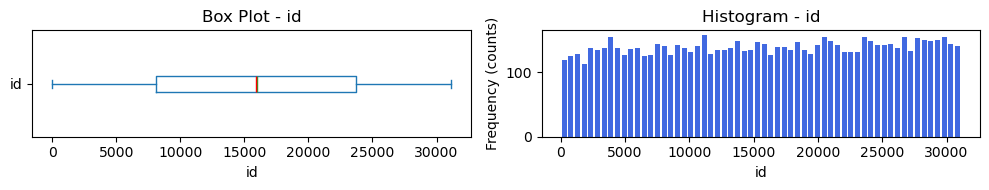

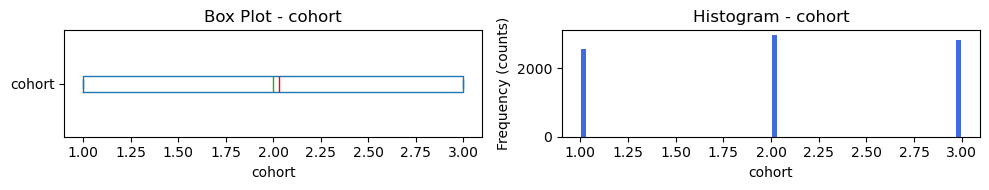

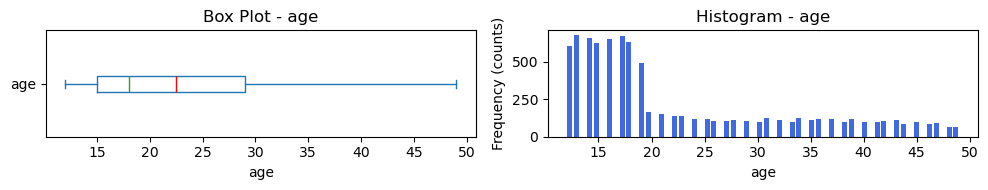

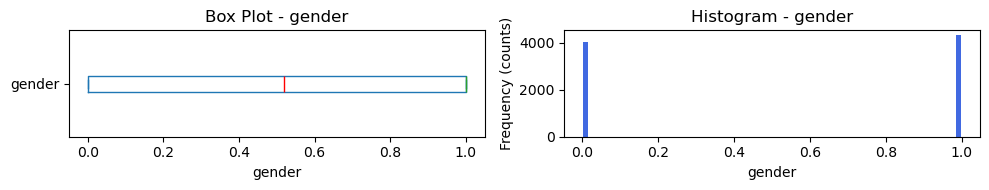

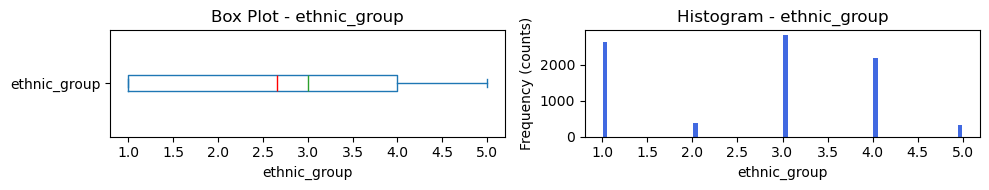

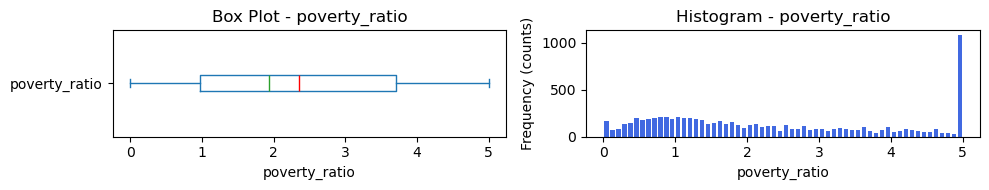

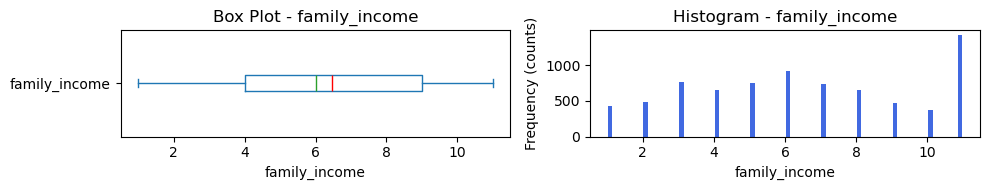

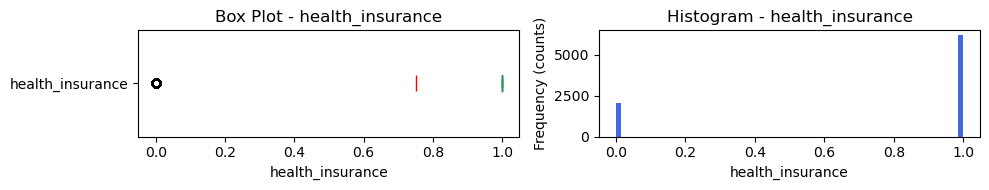

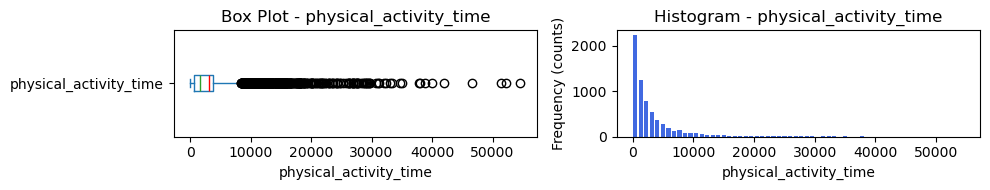

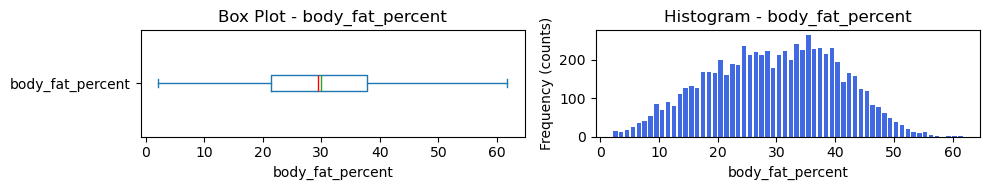

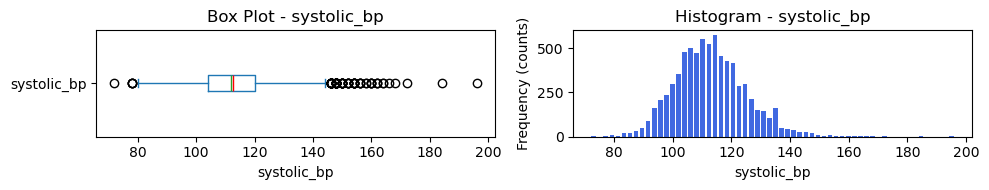

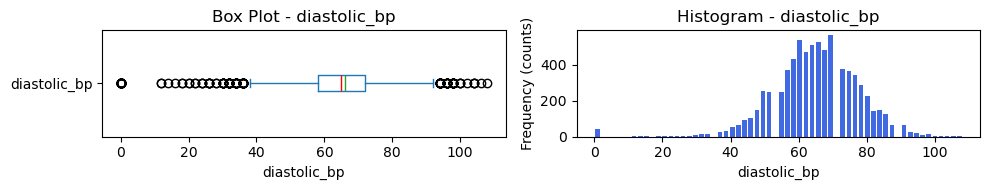

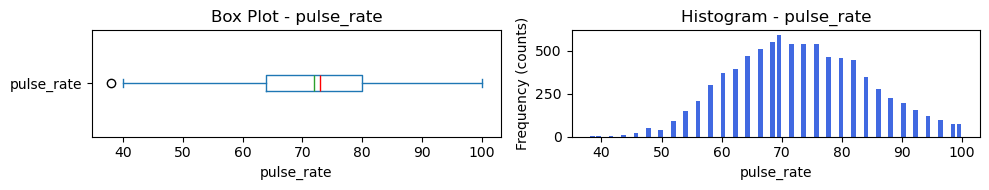

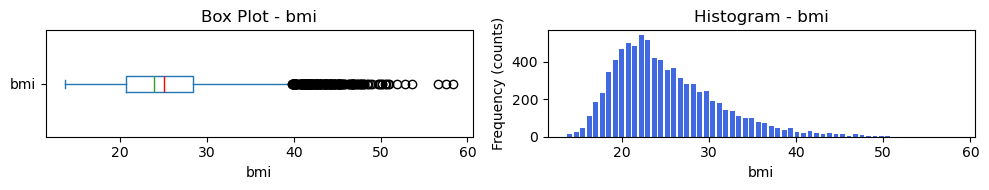

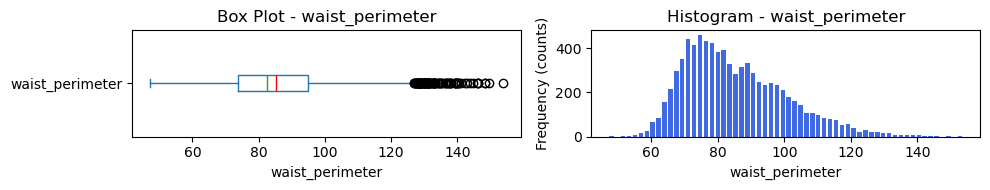

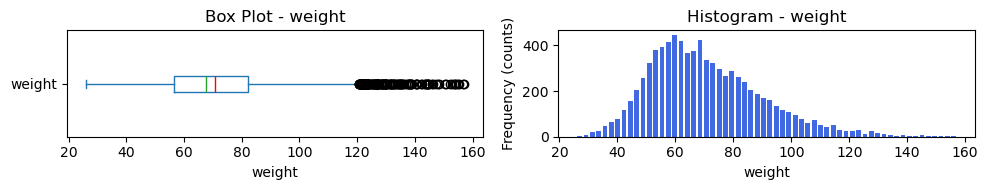

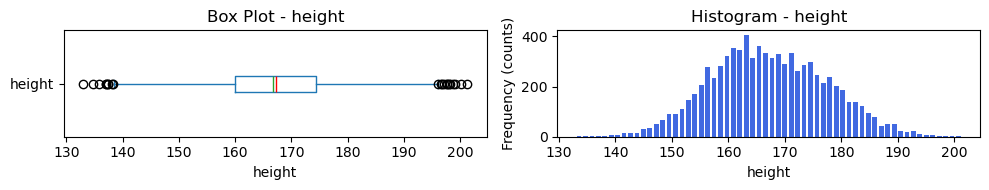

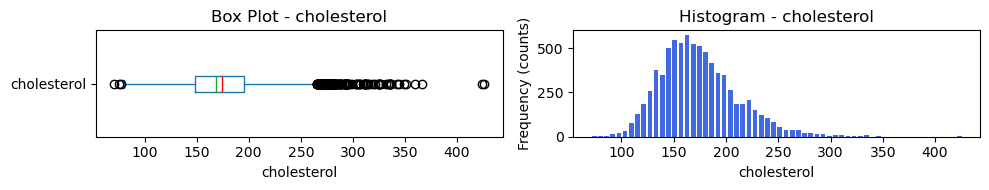

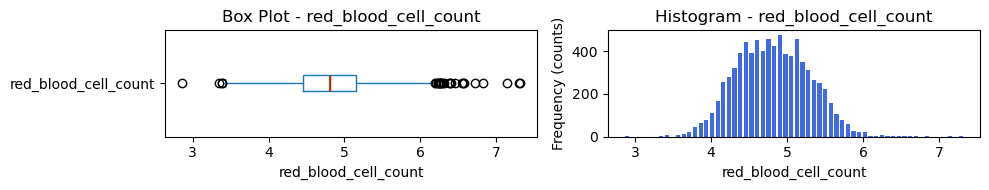

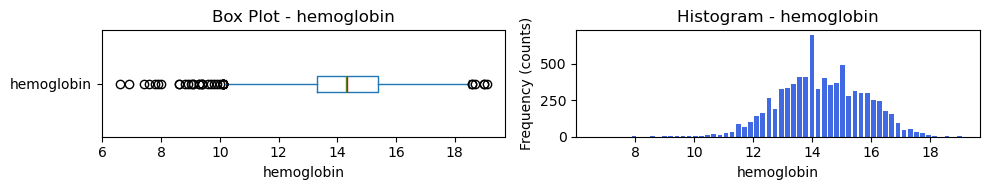

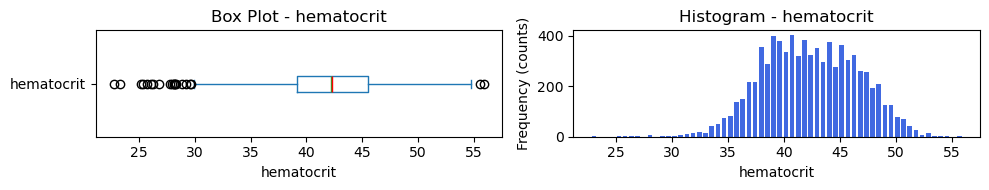

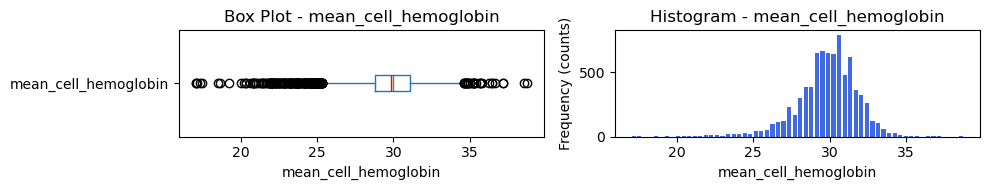

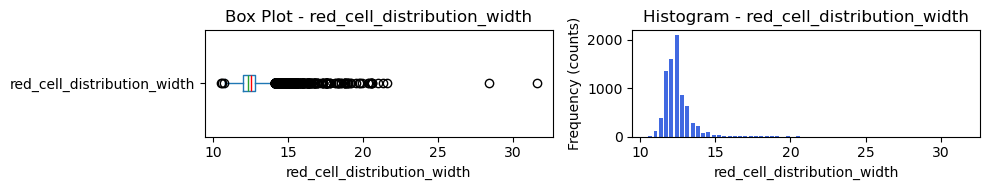

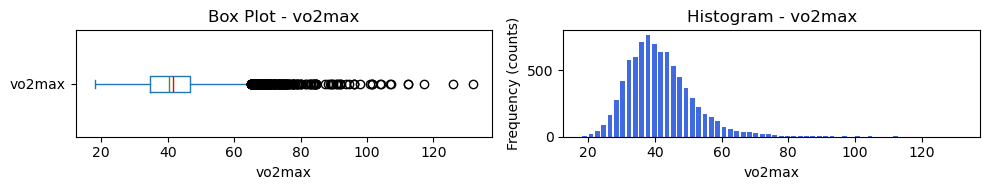

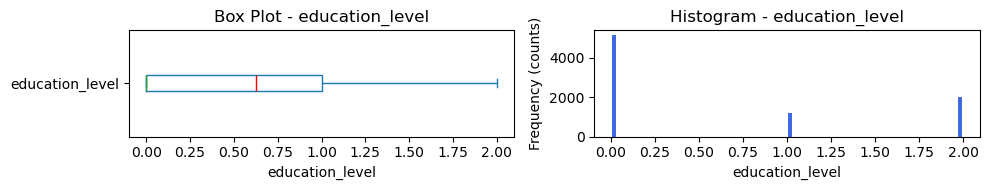

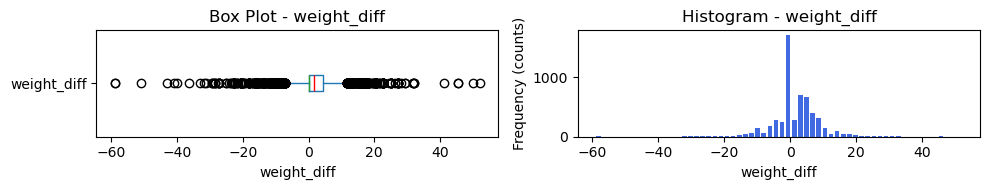

In [28]:
# Select numeric variables
numeric_columns = transformed_df.select_dtypes(include=['float', 'int']).columns

# Iterate over numeric variables
for variable in numeric_columns:
  # Create the figure
  fig, axes = plt.subplots(1, 2, figsize=(10, 2))

  # Plot 1 - BoxPlot
  transformed_df[variable].plot(kind='box', 
                                vert=False, 
                                showmeans=True,  # To show the mean
                                meanline=True,   # To show the mean line
                                meanprops={'color': 'red', 'linestyle': '-'}, # mean in red
                                ax=axes[0]
                                )
  axes[0].set_title(f'Box Plot - {variable}')
  axes[0].set_xlabel(variable)

  # Plot 2 - Histogram
  transformed_df[variable].plot(kind='hist',
                                bins=60,  # or bins = len(data[variable].value_counts())
                                rwidth=0.75,
                                color='royalblue',
                                ax=axes[1]
                                )
  axes[1].set_title(f'Histogram - {variable}')
  axes[1].set_xlabel(variable)
  axes[1].set_ylabel('Frequency (counts)')

  plt.tight_layout()  
  plt.show()

Once the distribution of the variables was observed, it was decided to apply a **multivariate method (K-Nearest Neighbor)**, as it outperforms simpler methods such as imputing by mean or median. This approach was chosen for all cases except for `weight_diff`, where it was decided to replace missing values with the mean value, i.e., 0, assuming there was no weight difference over the year. This is summarized in the following table:



| **Column**                | **Type**             | **Selected Method**                                      |
|---------------------------|----------------------|-------------------------------------------------------------|
| `id`                      | Identifier           | None                                                        |
| `cohort`                  | Ordinal categorical  | None                                                        |
| `age`                     | Continuous           | None                                                        |
| `gender`                  | Binary               | None                                                        |
| `ethnic_group`            | Categorical          | None                                                        |
| `poverty_ratio`           | Continuous           | **KNN Imputer**                                               |
| `family_income`           | Ordinal discrete     | **KNN Imputer** + discrete transformation                                              |
| `health_insurance`        | Binary               | **KNN Imputer** + binary transformation                                             |
| `physical_activity_time`  | Continuous           | **KNN Imputer**                                              |
| `systolic_bp`             | Continuous           | **KNN Imputer**                                              |
| `diastolic_bp`            | Continuous           | **KNN Imputer**                                              |
| `pulse_rate`              | Continuous           | None                                                        |
| `bmi`                     | Continuous           | **KNN Imputer**                                              |
| `waist_perimeter`         | Continuous           | **KNN Imputer**                                              |
| `body_fat_percent`        | Continuous           | **KNN Imputer**                                              |
| `weight`                  | Continuous           | **KNN Imputer**                                              |
| `height`                  | Continuous           | **KNN Imputer**                                              |
| `cholesterol`             | Continuous           | **KNN Imputer**                                              |
| `red_blood_cell_count`    | Continuous           | **KNN Imputer**                                              |
| `hemoglobin`             | Continuous           | **KNN Imputer**                                              |
| `hematocrit`             | Continuous           | **KNN Imputer**                                              |
| `mean_cell_hemoglobin`             | Continuous           | **KNN Imputer**                                              |
| `red_cell_distribution_width`             | Continuous           | **KNN Imputer**                                              |
| `vo2max`                  | Continuous           | None                                                        |
| `education_level`         | Ordinal discrete     | None                                                        |
| `weight_diff`             | Continuous           | **Assign 0 to missing values**                               |

The [**KNN Imputer**](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) (K-Nearest Neighbors Imputer) is a technique for imputing missing values by utilizing the values of the nearest neighbors in the feature space. 
- It works by finding the *k* most similar samples (neighbors) to the missing data point based on the feature values and imputing the missing value using the average (or weighted average) of these neighbors' corresponding values. The *k* default value is 5.
  
- This method is particularly useful, as it captures the patterns and correlations in the data. In this case, I have applied the KNN Imputer to variables with missing values to preserve the structure and correlations of the dataset, improving the quality of the imputation over simpler methods like mean or median imputation.


In [29]:
from sklearn.impute import KNNImputer


# Initialize the KNN Imputer with the number of neighbors (k) and distance metric
knn_imputer = KNNImputer(n_neighbors=5, 
                         metric='nan_euclidean')  # Use 'nan_euclidean' to handle missing values during distance computation

# Select the columns that require KNN imputation
columns_to_impute = [
    'poverty_ratio', 
    'family_income', 
    'health_insurance', 
    'physical_activity_time', 
    'systolic_bp', 
    'diastolic_bp', 
    'bmi', 
    'waist_perimeter',
    'body_fat_percent',
    'weight', 
    'height', 
    'cholesterol',
    'red_blood_cell_count',
    'hemoglobin',
    'hematocrit',
    'mean_cell_hemoglobin',
    'red_cell_distribution_width',
]
cleaned_df = transformed_df.copy()
# Apply KNN Imputer to the selected columns
cleaned_df[columns_to_impute] = knn_imputer.fit_transform(cleaned_df[columns_to_impute])

In [30]:
# For 'weight_diff', assign 0 to missing values as it represents no weight difference
cleaned_df['weight_diff'] = cleaned_df['weight_diff'].fillna(0).infer_objects()

# Verifying that there are no missing values left
cleaned_df.isnull().sum()  

id                             0
cohort                         0
age                            0
gender                         0
ethnic_group                   0
poverty_ratio                  0
family_income                  0
health_insurance               0
physical_activity_time         0
body_fat_percent               0
systolic_bp                    0
diastolic_bp                   0
pulse_rate                     0
bmi                            0
waist_perimeter                0
weight                         0
height                         0
cholesterol                    0
red_blood_cell_count           0
hemoglobin                     0
hematocrit                     0
mean_cell_hemoglobin           0
red_cell_distribution_width    0
vo2max                         0
education_level                0
weight_diff                    0
smoker                         0
dtype: int64

**Handling Discrete Variables After KNN Imputation**

After applying the KNN Imputer to the `family_income` and `health_insurance` columns, the imputed values for these variables were continuous, which is not appropriate since both are discrete variables. Specifically:

- **`family_income`** is an ordinal variable that takes integer values from 1 to 11, corresponding to discrete income ranges. After imputation, some imputed values may fall between these integer values, which would make them unrealistic for an ordinal variable. 
- **`health_insurance`** is a binary variable that takes values of either `0` (no insurance) or `1` (with insurance). Imputed values may fall between `0` and `1`, which would be inconsistent with its binary nature.

To address this, we applied custom transformations to round the imputed values:
1. For **`family_income`**, continuous values were grouped into bins, with each bin corresponding to a specific integer value from 1 to 11.
2. For **`health_insurance`**, values were rounded to either `0` or `1`, depending on whether they were closer to `0` or `1`.

This approach ensures that the data remains consistent with the expected format for each variable, while still leveraging the power of KNN imputation for missing data handling.


In [31]:
# Transform 'family_income' to convert continuous values into discrete values (1 to 11)
def transform_family_income(value):
    if 0.5 <= value < 1.5:
        return 1
    elif 1.5 <= value < 2.5:
        return 2
    elif 2.5 <= value < 3.5:
        return 3
    elif 3.5 <= value < 4.5:
        return 4
    elif 4.5 <= value < 5.5:
        return 5
    elif 5.5 <= value < 6.5:
        return 6
    elif 6.5 <= value < 7.5:
        return 7
    elif 7.5 <= value < 8.5:
        return 8
    elif 8.5 <= value < 9.5:
        return 9
    elif 9.5 <= value < 10.5:
        return 10
    elif 10.5 <= value <= 11:
        return 11

# Apply the function to the 'family_income' column
cleaned_df['family_income'] = cleaned_df['family_income'].apply(transform_family_income)

# Transform 'health_insurance' to make sure the values are either 0 or 1
cleaned_df['health_insurance'] = cleaned_df['health_insurance'].apply(lambda x: 0 if x < 0.5 else 1)

**Reordering some columns...**

In [32]:
# Desired column order
ordered_columns = [
    'id',
    'cohort',
    'age',
    'gender',
    'ethnic_group',
    'poverty_ratio',
    'family_income',
    'education_level',
    'health_insurance',
    'smoker',
    'physical_activity_time',
    'systolic_bp',
    'diastolic_bp',
    'pulse_rate',
    'bmi',
    'waist_perimeter',
    'body_fat_percent',
    'weight_diff',
    'weight',
    'height',
    'cholesterol',
    'red_blood_cell_count',
    'hemoglobin',
    'hematocrit',
    'mean_cell_hemoglobin',
    'red_cell_distribution_width',
    'vo2max'
]

# Reorder the DataFrame
cleaned_df = cleaned_df[ordered_columns]

etl.descriptors(cleaned_df)

,count,mean,std,min,25%,50%,75%,max,unique_values,null_values
id,8324.0,15888.160980,8966.243604,5.000000e+00,8129.750,15964.500,23725.500000,31119.000000,8324,0
cohort,8324.0,2.029793,0.802691,1.000000e+00,1.000,2.000,3.000000,3.000000,3,0
age,8324.0,22.456151,10.385105,1.200000e+01,15.000,18.000,29.000000,49.000000,38,0
gender,8324.0,0.517900,0.499710,0.000000e+00,0.000,1.000,1.000000,1.000000,2,0
ethnic_group,8324.0,2.663023,1.268751,1.000000e+00,1.000,3.000,4.000000,5.000000,5,0
poverty_ratio,8324.0,2.320385,1.559402,5.397605e-79,1.020,1.940,3.540000,5.000000,967,0
family_income,8324.0,6.423715,3.057198,1.000000e+00,4.000,6.000,9.000000,11.000000,11,0
education_level,8324.0,0.626141,0.846685,0.000000e+00,0.000,0.000,1.000000,2.000000,3,0
health_insurance,8324.0,0.753844,0.430796,0.000000e+00,1.000,1.000,1.000000,1.000000,2,0
physical_activity_time,8324.0,3078.455286,3970.569434,0.000000e+00,780.000,1846.000,3780.000000,54600.000000,2772,0


-------------------------
<a id =warehouse><a/>

[Go to index](#id_0)
## 2. Data Warehouse in PostgreSQL

The objective of this project is to create a clean, structured PostgreSQL database to store biometric data, intended for future use in various machine learning projects. The stored data should serve as a ***single source of truth***.

<a id =connection><a/>
### 2.1. Connection to PostgreSQL

To interact with the PostgreSQL database, the `psycopg2` library has been used, which provides a direct interface between Python and PostgreSQL. A connection was established by providing the required parameters: database name, user, password, host, and port. Once connected, a cursor object was created to execute SQL commands.

In [33]:
from dotenv import load_dotenv, find_dotenv
import psycopg2


# This earch for the nearest .env upwards in the folder tree
load_dotenv(find_dotenv())

# Establish the connection to the PostgreSQL database
connection = psycopg2.connect(
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    database=os.getenv("DB_NAME")
)

# Create a cursor object to execute SQL queries
cursor = connection.cursor()

-------------------------
<a id =storing><a/>

[Go to index](#id_0)
### 2.2. Storing the Data

A table named `biometrics` has been created to hold the cleaned dataset. The schema was defined using standard SQL types (e.g., `FLOAT`, `INTEGER`, `TEXT`). After defining the table structure, the cleaned_df DataFrame from pandas was converted to a list of tuples and inserted into the table using [`psycopg2.extras.execute_values`](https://www.psycopg.org/docs/extras.html), which efficiently inserts multiple rows at once.

In [34]:
# SQL query to create the 'biometrics' table if it doesn't already exist
create_table_sql = """
    CREATE TABLE IF NOT EXISTS biometrics (
    id                          FLOAT PRIMARY KEY,
    cohort                      FLOAT,
    age                         FLOAT,
    gender                      FLOAT,
    ethnic_group                FLOAT,
    poverty_ratio               FLOAT,
    family_income               INTEGER,
    education_level             INTEGER,
    health_insurance            INTEGER,
    smoker                      TEXT,
    physical_activity_time      FLOAT,
    systolic_bp                 FLOAT,
    diastolic_bp                FLOAT,
    pulse_rate                  FLOAT,
    bmi                         FLOAT,
    waist_perimeter             FLOAT,
    body_fat_percent            FLOAT,
    weight_diff                 FLOAT,
    weight                      FLOAT,
    height                      FLOAT,
    cholesterol                 FLOAT,
    red_blood_cell_count        FLOAT,
    hemoglobin                  FLOAT,
    hematocrit                  FLOAT,
    mean_cell_hemoglobin        FLOAT,
    red_cell_distribution_width FLOAT,
    vo2max                      FLOAT
);
"""

# Execute the SQL query to create the table
cursor.execute(create_table_sql)

# Commit the changes to the database (applies the create table operation)
connection.commit()

In [35]:
# Convert 'cleaned_df' to a list of tuples to insert it into the database
data = cleaned_df.values.tolist()

# SQL query to insert data into the 'biometrics' table
insert_sql = """
    INSERT INTO biometrics (
        id, cohort, age, gender, ethnic_group, poverty_ratio, family_income,
        education_level, health_insurance, smoker, physical_activity_time,
        systolic_bp, diastolic_bp, pulse_rate, bmi, waist_perimeter,
        body_fat_percent, weight_diff, weight, height, cholesterol,
        red_blood_cell_count, hemoglobin, hematocrit, mean_cell_hemoglobin,
        red_cell_distribution_width, vo2max
    ) VALUES %s
"""
# Use 'execute_values' from psycopg2.extras to insert multiple rows at once
from psycopg2.extras import execute_values

# Insert the data into the table
execute_values(cursor, insert_sql, data)

# Commit the changes to the database
connection.commit()

# Print a confirmation message with the number of rows inserted
print(f"{len(data)} rows inserted into the 'biometrics' table.")

8324 rows inserted into the 'biometrics' table.


- In addition to storing the data in PostgreSQL, **the cleaned dataset has also been saved as a `.csv` file in the `data/processed/` folder**. This ensures that the dataset is easily accessible directly from the repository for analysis, visualization, or testing purposes, without requiring a connection to the database. To maintain security and reproducibility, database credentials are stored in a separate `.env` file, while a template file `.env.example` is provided in the repository. This allows other users to recreate the PostgreSQL database locally by supplying their own credentials without exposing sensitive information.


In [36]:
cleaned_df.to_csv("../data/processed/biometrics.csv", index=False)

-------------------------
<a id =metadata><a/>

[Go to index](#id_0)
### 2.3. Storing Metadata

To enhance the usability and clarity of the dataset, a **secondary table** named `biometrics_metadata` has been created to store metadata. This table includes information about each variable in the biometrics table: the column name, description, data type, additional comments and source. 

In [37]:
# SQL query to create the 'data_dictionary' table
create_table_sql = """
    CREATE TABLE IF NOT EXISTS biometrics_metadata (
        column_name        TEXT PRIMARY KEY,    -- The name of the column (e.g., 'id', 'age', etc.)
        description        TEXT,                 -- A short description of the column
        data_type          TEXT,                 -- The type of data stored (e.g., 'FLOAT', 'INTEGER')
        comments           TEXT,                 -- Additional comments or notes about the column
        source             TEXT                  -- Source: created during ETL or NHANES link 
    );
"""
# Execute the SQL query to create the table
cursor.execute(create_table_sql)

# Commit the changes to apply the table creation
connection.commit()

In [38]:
# Insert metadata into 'biometrics_metadata' table
insert_metadata_sql = """
INSERT INTO biometrics_metadata (column_name, description, data_type, comments, source)
VALUES
('id', 'Unique identifier for each participant', 'FLOAT', 'Primary key for the table', 'NHANES'),
('cohort', 'Cohort to which the participant belongs', 'FLOAT', 'NHANES cohort identifier {1: 1999-2000, 2: 2001-2002, 3: 2003-2004}', 'NHANES'),
('age', 'Age of the participant in years', 'FLOAT', 'Age calculated from birthdate', 'NHANES'),
('gender', 'Gender of the participant', 'FLOAT', '1 = Male, 2 = Female', 'NHANES'),
('ethnic_group', 'Reported race and ethnicity information', 'FLOAT', 'Categorical: {1 = Mexican American, 2 = Other Hispanic, 3 = Non-Hispanic White, 4 = Non-Hispanic Black, 5 = Other / Multi-Racial}', 'NHANES'),
('education_level', 'Education level of the participant', 'INTEGER', '{0: less than high school, 1 = high school, 2 = greater than high school}', 'Created during ETL'),
('poverty_ratio', 'Poverty ratio of the participant', 'FLOAT', 'Ratio of income to poverty line', 'NHANES'),
('family_income', 'Annual family income of the participant', 'INTEGER', '1: "$0-$4,999", 2: "$5,000-$9,999", 3: "$10,000-$14,999", 4: "$15,000-$19,999", 5: "$20,000-$24,999", 6: "$25,000-$34,999", 7: "$35,000-$44,999", 8: "$45,000-$54,999", 9: "$55,000-$64,999", 10: "$65,000-$74,999", 11: "$75,000 and over"', 'NHANES'),
('health_insurance', 'Health insurance status', 'INTEGER', '1 = Insured, 0 = Not insured', 'NHANES'),
('smoker', 'Smoking status of the participant', 'TEXT', 'Smoker, Non-smoker, Former', 'Created during ETL'),
('physical_activity_time', 'Time spent on physical activity', 'FLOAT', 'Minutes per month of moderate physical activity','Created during ETL'),
('systolic_bp', 'Systolic blood pressure', 'FLOAT', 'Blood pressure measurement (mmHg)', 'NHANES'),
('diastolic_bp', 'Diastolic blood pressure', 'FLOAT', 'Blood pressure measurement (mmHg)', 'NHANES'),
('pulse_rate', 'Pulse rate of the participant', 'FLOAT', 'Heart rate in beats per minute', 'NHANES'),
('bmi', 'Body mass index', 'FLOAT', 'Weight (kg) / Height (m)^2', 'NHANES'),
('waist_perimeter', 'Waist circumference', 'FLOAT', 'Waist measurement in centimeters', 'NHANES'),
('body_fat_percent', 'Estimated body fat percentage (%)', 'FLOAT', 'Calculated from bioimpedance', 'NHANES'),
('weight_diff', 'Difference in weight from the baseline', 'FLOAT', 'Weight change (kg)', 'NHANES'),
('weight', 'Weight of the participant', 'FLOAT', 'Weight in kilograms', 'NHANES'),
('height', 'Height of the participant', 'FLOAT', 'Height in centimeters', 'NHANES'),
('cholesterol', 'Cholesterol level', 'FLOAT', 'Cholesterol level in mg/dL', 'NHANES'),
('red_blood_cell_count', 'Red blood cell count', 'FLOAT', 'Number of red blood cells per volume', 'NHANES'),
('hemoglobin', 'Hemoglobin concentration (g/dL)', 'FLOAT', 'Hemoglobin in g/dL', 'NHANES'),
('hematocrit', 'Hematocrit percentage (%)', 'FLOAT', 'Percentage of blood volume occupied by red blood cells', 'NHANES'),
('mean_cell_hemoglobin', 'Mean cell hemoglobin (pg)', 'FLOAT', 'Average hemoglobin per red blood cell', 'NHANES'),
('red_cell_distribution_width', 'Red cell distribution width (%)', 'FLOAT', 'Variation in red blood cell size', 'NHANES'),
('vo2max', 'Maximal oxygen uptake', 'FLOAT', 'Maximum amount of oxygen used during intense exercise', 'NHANES');
"""

# Execute the SQL to insert metadata
cursor.execute(insert_metadata_sql)

# Commit the changes to save the data
connection.commit()

In [39]:
# Close the cursor and connection
cursor.close()
connection.close()

Finally, the cursor and the connection to the PostgreSQL server were closed.
